# Practical classes

All exercices will be in Python. It is important that you keep track of exercices and structure you code correctly (e.g. create funcions that you can re-use later)

We will use Jupyter notebooks (formerly known as IPython). You can read the following courses for help:
* Python and numpy: http://cs231n.github.io/python-numpy-tutorial/
* Jupyter / IPython : http://cs231n.github.io/ipython-tutorial/

To run this notebook:
* create a directory somewhere on your filesystem
* download the .ipynb from the course website: http://teaching.caio-corro.fr/2019-2020/OPT8/
* move the .ipynb into the directory
* from a terminal:
    * cd /directory/path
    * jupyter notebook

Each group must send me their work by e-mail (one mail per group) before next course:
* complete the code with comments
* quick report on what's going one, experimental results etc.

If you don't want to use the notebook, send me the python code + a PDF with plots and answers.


# Neural network: first experiments with a linear model

In this first lab exercise we will code a neural network using numpy, without a neural network library.
Next week, the lab exercise will be to extend this program with hidden layers and activation functions.

The task is digit recognition: the neural network has to predict which digit in $\{0...9\}$ is written in the input picture. We will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a standard benchmark in machine learning.

The model is a simple linear  classifier $o = \operatorname{softmax}(Wx + b)$ where:
* $x$ is an input image that is represented as a column vector, each value being the "color" of a pixel
* $W$ and $b$ are the parameters of the classifier
* $\operatorname{softmax}$ transforms the output weight (logits) into probabilities
* $o$ is column vector that contains the probability of each category

We will train this model via stochastic gradient descent by minimizing the negative log-likelihood of the data:
$$
    \hat{W}, \hat{b} = \operatorname{argmin}_{W, b} \sum_{x, y} - \log p(y | x)
$$
Although this is a linear model, it classifies raw data without any manual feature extraction step.

In [22]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# 1. Data

In [23]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [24]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

Each dataset is a list with two elemets:
* data[0] contains images
* data[1] contains labels

Data is stored as numpy.ndarray. You can use data[0][i] to retrieve image number i and data[1][i] to retrieve its label.

In [25]:
print(type(train_data))
print(type(train_data[0]))
print(type(train_data[1]))
print(type(train_data[0][0]))
print(type(train_data[1][0]))

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>


label: 4


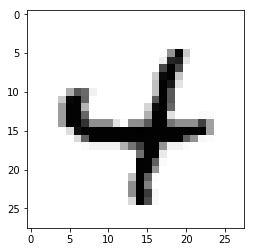

In [26]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

In [27]:
len(train_data[1])

50000

**Question:** What are the characteristics of training data? (number of samples, dimension of input, number of labels)

The documentation of ndarray class is available here: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html

In [28]:
def getDimDataset(data):
    n_training = len(train_data[0])
    n_feature = len(train_data[0][0])
    n_label = len(set(train_data[1]))
    return n_training, n_feature, n_label

In [29]:
getDimDataset(train_data)

(50000, 784, 10)

# 1. Building functions

We now need to build functions that are required for the neural network.
$$
    o = \operatorname{softmax}(Wx + b) \\
    L(x, y) = -\log p(y | x) = -\log o[y]
$$

Note that in numpy, operator @ is used for matrix multiplication while * is used for element-wise multiplication.
The documentation for linear algebra in numpy is available here: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html

The first operation is the affine transformation $v = Wx + b$.
To compute the gradient, it is often convenient to write the forward pass as $v[i] = b[i] + \sum_j W[i, j] x[j]$.

In [30]:
# Input:
# - W: projection matrix
# - b: bias
# - x: input features
# Output:
# - vector
def affine_transform(W, b, x):
    v = W.dot(x) + b
    return v

# Input:
# - W: projection matrix
# - b: bias
# - x: input features
# - g: incoming gradient
# Output:
# - g_W: gradient wrt W
# - g_b: gradient wrt b
def backward_affine_transform(W, b, x, g):
    g_W = g.reshape(g.shape[0],1)@x.reshape(x.shape[0],1).T
    g_b = g
    return g_W, g_b

The next cell is a (too simple) test of affine_transform and backward_affine_transform.
It should run without error if your implementation is correct.

In [31]:
W = np.asarray([[ 0.63024213,  0.53679375, -0.92079597],
 [-0.1155045,   0.62780356, -0.67961305],
 [ 0.08465286, -0.06561815, -0.39778322],
 [ 0.8242268,   0.58907262, -0.52208052],
 [-0.43894227, -0.56993247,  0.09520727]])
b = np.asarray([ 0.42706842,  0.69636598, -0.85611933, -0.08682553,  0.83160079])
x = np.asarray([-0.32809223, -0.54751413,  0.81949319])

o_gold = np.asarray([-0.82819732, -0.16640748, -1.17394705, -1.10761496,  1.36568213])
g = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])
g_W_gold = np.asarray([[ 0.02932773,  0.04894156, -0.07325341],
 [-0.14463576, -0.24136543,  0.36126434],
 [ 0.07417322,  0.12377887, -0.18526635],
 [ 0.31561399,  0.52669067, -0.78832562],
 [ 0.17529576,  0.29253025, -0.43784542]])
g_b_gold = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])


# quick test of the forward pass
o = affine_transform(W, b, x)
if o.shape != o_gold.shape:
    raise RuntimeError("Unexpected output dimension: got %s, expected %s" % (str(o.shape), str(o_gold.shape)))
if not np.allclose(o, o_gold):
    raise RuntimeError("Output of the affine_transform function is incorrect")
    
# quick test if the backward pass
g_W, g_b = backward_affine_transform(W, b, x, g)
if g_W.shape != g_W_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for W: got %s, expected %s" % (str(g_W.shape), str(g_W_gold.shape)))
if g_b.shape != g_b_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for b: got %s, expected %s" % (str(g_b.shape), str(g_b_gold.shape)))
if not np.allclose(g_W, g_W_gold):
    raise RuntimeError("Gradient of W is incorrect")
if not np.allclose(g_b, g_b_gold):
    raise RuntimeError("Gradient of b is incorrect")

The softmax function:
$$
     o = \operatorname{softmax}(w)
$$
where $w$ is a vector of logits in $\mathbb R$ and $o$ a vector of probabilities such that:
$$
    o[i] = \frac{\exp(w[i])}{\sum_j \exp(w[j])}
$$
We do not need to implement the backward for this experiment.

In [58]:
# Input:
# - x: vector of logits
# Output
# - vector of probabilities
def softmax(x):
    b = np.max(x)
    y = np.exp(x - b)
    return y / y.sum()

**WARNING:** is your implementation numerically stable?

The $\exp$ function results in computations that overflows (i.e. results in numbers that cannot be represented with floating point numbers).
Therefore, it is always convenient to use the following trick to improve stability: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

In [77]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [1000000,1,100]
print(softmax(z))

[1. 0. 0.]


**Question**: from the result of the cell above, what can you say about the softmax output, even when it is stable?

In [34]:
# Just too simple test for the softmax function
x = np.asarray([0.92424884, -0.92381088, -0.74666024, -0.87705478, -0.54797015])
y_gold = np.asarray([0.57467369, 0.09053556, 0.10808233, 0.09486917, 0.13183925])

y = softmax(x)
if not np.allclose(y, y_gold):
    raise RuntimeError("Output of the softmax function is incorrect")

Finally, we build the loss function and its gradient for training the network.

The loss function is the negative log-likelihood defined as:
$$
    \mathcal L(x, gold) = -\log \frac{\exp(x[gold])}{\sum_j \exp(x[j])} = -x[gold] + \log \sum_j \exp(x[j])
$$
This function is also called the cross-entropy loss (in Pytorch, different names are used dependending if the inputs are probabilities or raw logits).

Similarly to the softmax, we have to rely on the log-sum-exp trick to stabilize the computation: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

In [68]:
# Input:
# - x: vector of logits
# - gold: index of the gold class
# Output:
# - scalare equal to -log(softmax(x)[gold])
def nll(x, gold):
    return(-np.log(softmax(x)[gold]))

# Input:
# - x: vector of logits
# - gold: index of the gold class
# - gradient (scalar)
# Output:
# - gradient wrt x
def backward_nll(x, gold, g):
    g_x = np.zeros((len(x),1))
    g_x[gold]= -1
    g_x += softmax(x)
    g_x = g_x * g
    return g_x

In [36]:
# test
x = np.asarray([-0.13590009, -0.83649656,  0.03130881,  0.42559402,  0.08488182])
y_gold = 1.5695014420179738
g_gold = np.asarray([ 0.17609875,  0.08739591, -0.79185107,  0.30875221,  0.2196042 ])

y = nll(x, 2)
g = backward_nll(x, 2, 1.)

if not np.allclose(y, y_gold):
    raise RuntimeError("Output is incorrect")

if g.shape != g_gold.shape:
        raise RuntimeError("Unexpected gradient dimension: got %s, expected %s" % (str(g.shape), str(g_gold.shape)))
if not np.allclose(g, g_gold):
    raise RuntimeError("Gradient is incorrect")

The following code test the implementation of the gradient using finite-difference approximation, see: https://timvieira.github.io/blog/post/2017/04/21/how-to-test-gradient-implementations/

Your implementation should pass this test.

In [37]:
# this is python re-implementation of the test from the Dynet library
# https://github.com/clab/dynet/blob/master/dynet/grad-check.cc

def is_almost_equal(grad, computed_grad):print
    #print(grad, computed_grad)
    f = abs(grad - computed_grad)
    m = max(abs(grad), abs(computed_grad))

    if f > 0.01 and m > 0.:
        f /= m

    if f > 0.01 or math.isnan(f):
        return False
    else:
        return True

def check_gradient(function, weights, true_grad, alpha = 1e-3):
    # because input can be of any dimension,
    # we build a view of the underlying data with the .shape(-1) method
    # then we can access any element of the tensor as a elements of a list
    # with a single dimension
    weights_view = weights.reshape(-1)
    true_grad_view = true_grad.reshape(-1)
    for i in range(weights_view.shape[0]):
        old = weights_view[i]

        weights_view[i] = old - alpha
        value_left = function(weights).reshape(-1)

        weights_view[i] = old + alpha
        value_right = function(weights).reshape(-1)

        weights_view[i] = old
        grad = (value_right - value_left) / (2. * alpha)

        if not is_almost_equal(grad, true_grad_view[i]):
            return False

        return True

In [38]:
# Test the affine transformation

x = np.random.uniform(-1, 1, (5,))
W = np.random.uniform(-1, 1, (3, 5))
b = np.random.uniform(-1, 1, (3,))

for i in range(3):
    y = affine_transform(W, b, x)
    g = np.zeros_like(y)
    g[i] = 1.
    g_W, _ = backward_affine_transform(W, b, x, g)
    print(check_gradient(lambda W: affine_transform(W, b, x)[i], W, g_W))

True
True
True


In [39]:
# test the negative likelihood loss

x = np.random.uniform(-1, 1, (5,))

for gold in range(5):
    y = nll(x, gold)
    g_y = backward_nll(x, gold, 1.)

    print(check_gradient(lambda x: nll(x, gold), x, g_y))

True
True
True
True
True


# 2. Parameter initialization

We are now going to build the function that will be used to initialize the parameters of the neural network before training.
Note that for parameter initialization you must use **in-place** operations:

In [40]:
# create a random ndarray
a = np.random.uniform(-1, 1, (5,))

# this does not change the data of the ndarray created above!
# it creates a new ndarray and replace the reference stored in a
a = np.zeros((5, ))

# this will change the underlying data of the ndarray that a points to
a[:] = 0

# similarly, this creates a new array and change the object pointed by a
a = a + 1

# while this change the underlying data of a
a += 1

For an affine transformation, it is common to:
* initialize the bias to 0
* initialize the projection matrix with Glorot initialization (also known as Xavier initialization)

The formula for Glorot initialization can be found in equation 16 (page 5) of the original paper: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [41]:
    print(g_x)
    print(softmax(x))def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    par = (6**(1/2))/np.sqrt((W.shape[0]) + (W.shape[1]))
    W[:]=  (np.random.uniform(-par, par , W.shape))
        

In [42]:
W = 
glorot_init(W)
print(W)

SyntaxError: invalid syntax (<ipython-input-42-47083e06b4ab>, line 1)

# 3. Building and training the neural network

In our simple example, creating the neural network is simply instantiating the parameters $W$ and $b$.
They must be ndarray object with the correct dimensions.

In [48]:
def create_parameters(dim_input, dim_output):
    W = np.ones((dim_output,dim_input))
    b = np.ones((dim_output,1))
    
    return W, b

The recent success of deep learning is (partly) due to the ability to train very big neural networks.
However, researchers became interested in building small neural networks to improve computational efficiency and memory usage.
Therefore, we often want to compare neural networks by their number of parameters, i.e. the size of the memory required to store the parameters.

In [44]:
def print_n_parameters(W, b):
    n = W.shape[0]* W.shape[1] + len(b)
    print("Number of parameters: %i" % (n))

We can now create the neural network and print its number of parameters:

In [51]:
dim_input = getDimDataset(train_data)[1]
dim_output = getDimDataset(train_data)[2]
W, b = create_parameters(dim_input, dim_output)
print_n_parameters(W, b)print

Number of parameters: 7850


Finally, the training loop!

The training loop should be structured as follows:
* we do **epochs** over the data, i.e. one epoch is one loop over the dataset
* at each epoch, we first loop over the data and update the network parameters with respect to the loss gradient
* at the end of each epoch, we evaluate the network on the dev dataset
* after all epochs are done, we evaluate our network on the test dataset and compare its performance with the performance on dev

During training, it is useful to print the following information:
* the mean loss over the epoch: it should be decreasing!
* the accuracy on the dev set: it should be increasing!
* the accuracy on the train set: it shoud be increasing!

If you observe a decreasing loss (+increasing accuracy on test data) but decreasing accuracy on dev data, your network is overfitting!

Once you have build **and tested** this a simple training loop, you should introduce the following improvements:
* instead of evaluating on dev after each loop on the training data, you can also evaluate on dev n times per epoch
* shuffle the data before each epoch
* instead of memorizing the parameters of the last epoch only, you should have a copy of the parameters that produced the best value on dev data during training and evaluate on test with those instead of the parameters after the last epoch
* learning rate decay: if you do not observe improvement on dev, you can try to reduce the step size

After you conducted (successful?) experiments, you should write a report with results.

In [95]:
#before training, we initialize the parameters of the network
zero_init(b)
glorot_init(W)

tab_loss = []
tab_acc = []
tab_acc_dev = []
n_epochs = 50 # number of epochs
step = 0.00001 # step size for gradient updates

for epoch in range(n_epochs):
    G_W = 0
    G_B = 0
    ok=0
    loss_mean = 0
    for data, lab in zip(train_data[0], train_data[1]):
        data = data.reshape((data.shape[0], 1))
        pred = affine_transform(W,b,data)
        g = backward_nll(pred, lab, 1)
        g_w, g_b = backward_affine_transform(W, b, data, g)
        
        #Updating step
        G_W-=g_w
        G_B-=g_b
        
        #Loss_mean
        loss_mean += nll(pred,lab)
        
        
    
        if(np.argmax(pred)==lab):
            ok+=1
        
    #Compute accuracy on the training data
    acc = ok/len(train_data[1])
    tab_acc.append(acc)
    
            
    ok=0
    #Compute accuracy on dev data
    for data,lab in zip(dev_data[0], dev_data[1]):
        data = data.reshape((data.shape[0], 1))
        pred = affine_transform(W,b,data)
        
        if(np.argmax(pred)==lab):
            ok+=1
        
    acc_dev = ok/len(dev_data[1])
    tab_acc_dev.append(acc_dev)
    
    
    #Update parameters
    W+=G_W*step
    b+=G_B*step
    
    #Compute mean loss on training data
    loss_mean /= len(train_data[1])
    tab_loss.append(loss_mean[0])
    
    
    
  
    
    #print('acc : {}'.format(acc))
    #print('Mean Loss : {}'.format(loss_mean[0]))
        
    
# Test evaluation
acc_test = 0
ok = 0


for data,lab in zip(test_data[0], test_data[1]):
    data = data.reshape((data.shape[0], 1))
    pred = affine_transform(W,b,data)
        
    if(np.argmax(pred)==lab):
        ok+=1
        
acc_test = ok/len(dev_data[1])


In [102]:
print('Accuracy on test data : {}'.format(acc_test))
print('Accuracy on dev data : {}'.format(acc_dev))
print('Accuracy on train data : {}'.format(acc))

Accuracy on test data : 0.8899
Accuracy on dev data : 0.8916
Accuracy on train data : 0.87818


Text(0.5, 1.0, 'Mean Loss')

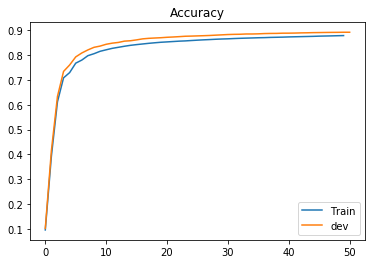

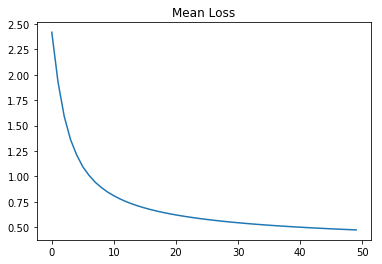

In [104]:
plt.plot(tab_acc , label='Train')
plt.plot(tab_acc_dev, label="dev")
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(tab_loss)
plt.title("Mean Loss")

In [106]:
import random
#before training, we initialize the parameters of the network
zero_init(b)
glorot_init(W)

tab_loss = []
tab_acc = []
tab_acc_dev = []
n_epochs = 50 # number of epochs
step = 0.00001 # step size for gradient updates

for epoch in range(n_epochs):
    G_W = 0
    G_B = 0
    ok=0
    loss_mean = 0
    tmp = list(zip(train_data[0], train_data[1]))
    random.shuffle(tmp)
    train_data[0], train_data[1] = zip(*tmp)

    for data, lab in zip(train_data[0], train_data[1]):
        data = data.reshape((data.shape[0], 1))
        pred = affine_transform(W,b,data)
        g = backward_nll(pred, lab, 1)
        g_w, g_b = backward_affine_transform(W, b, data, g)
        
        #Updating step
        G_W-=g_w
        G_B-=g_b
        
        #Loss_mean
        loss_mean += nll(pred,lab)
        
        
    
        if(np.argmax(pred)==lab):
            ok+=1
        
    #Compute accuracy on the training data
    acc = ok/len(train_data[1])
    tab_acc.append(acc)
    
            
    ok=0
    #Compute accuracy on dev data
    for data,lab in zip(dev_data[0], dev_data[1]):
        data = data.reshape((data.shape[0], 1))
        pred = affine_transform(W,b,data)
        
        if(np.argmax(pred)==lab):
            ok+=1
        
    acc_dev = ok/len(dev_data[1])
    tab_acc_dev.append(acc_dev)
    
    
    #Update parameters
    W+=G_W*step
    b+=G_B*step
    
    #Compute mean loss on training data
    loss_mean /= len(train_data[1])
    tab_loss.append(loss_mean[0])
    
    
    
  
    
    #print('acc : {}'.format(acc))
    #print('Mean Loss : {}'.format(loss_mean[0]))
        
    
# Test evaluation
acc_test = 0
ok = 0


for data,lab in zip(test_data[0], test_data[1]):
    data = data.reshape((data.shape[0], 1))
    pred = affine_transform(W,b,data)
        
    if(np.argmax(pred)==lab):
        ok+=1
        
acc_test = ok/len(dev_data[1])


Accuracy on test data : 0.8889
Accuracy on dev data : 0.8914
Accuracy on train data : 0.87824


Text(0.5, 1.0, 'Mean Loss')

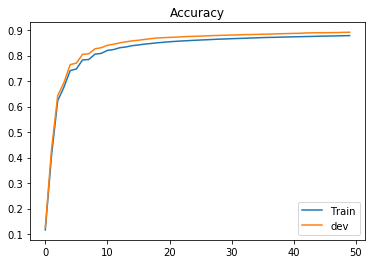

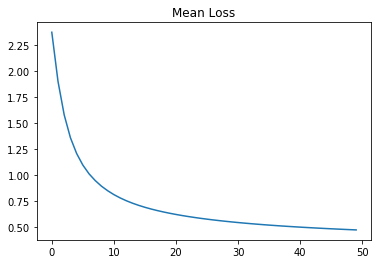

In [108]:
print('Accuracy on test data : {}'.format(acc_test))
print('Accuracy on dev data : {}'.format(acc_dev))
print('Accuracy on train data : {}'.format(acc))

plt.plot(tab_acc , label='Train')
plt.plot(tab_acc_dev, label="dev")
plt.title("Accuracy")
plt.legend()
plt.figure()

plt.plot(tab_loss)
plt.title("Mean Loss")